In [93]:
import torch
import torch.nn as nn 
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import defaultdict

In [95]:
@torch.no_grad()
def get_all_preds(model,dataloader): 
    all_preds = torch.tensor([])
    for batch in dataloader:
        images,labels = batch
        images = images.view(-1,32*32*3)
        preds = model(images)
        all_preds = torch.cat((all_preds,preds),dim=0)
        
    return all_preds

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Loading CIFAR-10 Data


In [96]:
trainset = dsets.CIFAR10('./data',train= True, download= True, transform= transforms.ToTensor())
testset = dsets.CIFAR10('./data', train = False, download= True, transform= transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Creating Mini-batches


In [99]:
torch.manual_seed(28)
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
print("Number of Epochs: ",num_epochs)


train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                           batch_size= batch_size, shuffle=True)



Number of Epochs:  10


In [100]:
def hinge_loss(ground_truths,output):
    
    num_class = 10
    loss_label = 0
    
    for i,label in enumerate(ground_truths):
        correct_class = output[i][label]
    
        for cls in range(num_class):
            if(cls==label):
                continue
            loss_label += max(0,output[i][cls]-correct_class+1)
        
    loss = loss_label/ground_truths.shape[0]
    
    return loss




## Building Model

In [101]:
class LogisticRegressionModel(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(LogisticRegressionModel,self).__init__()
        self.linear1 = nn.Linear(input_dim,2048)
        self.linear2 = nn.Linear(2048, 2048)
        self.relu = nn.ReLU() #activation function
        self.linear3 = nn.Linear(2048, 2048)
        self.linear4 = nn.Linear(2048, 1024)
        self.linear5 = nn.Linear(1024, output_dim)

        self.drop1 = nn.Dropout(0.2)
                
        self.seq_model = nn.Sequential(self.linear1,self.drop1,self.relu,
                                       self.linear2,self.relu,
                                       self.linear3,self.relu,
                                       self.linear4,self.relu,self.linear5)
        
        
    def forward(self,x):
        
        #out = self.relu(self.linear1(x))
        #output = self.linear2(out)
        output = self.seq_model(x)
        return output
    
    def train_model(self,data_loader,optimizer,epoch):
        iter = 0 
        accuracy=0
        
        total_loss = []
        self.train()
        
        for epoch in range(num_epochs):
            running_loss = 0
            for i,(images,labels) in enumerate (data_loader):
                images = images.view(-1,32*32*3)
                                
                #clear gradient w.r.t parameters
                optimizer.zero_grad()
                
                # Forward Propagation
                outputs = model(images)
                
                # Calculate Loss
                loss = hinge_loss(labels,outputs)
                #print(loss)
                                
                # Backpropagation
                # Get the grads w.r.t params
                loss.backward()
                # update params
                optimizer.step()
                   
                iter += 1 
                if iter % 500 ==0:
                    correct = 0 
                    total = 0 
                    self.eval()
                    
                    for test_imgs,test_labels in test_loader: 
                        test_imgs = test_imgs.view(-1,32*32*3)
                        test_output = model(test_imgs)
                        _,predicted = torch.max(test_output.data,1)
                        
                        # Total Number of labels
                        total += test_labels.size(0)
                        # Total correct prediction
                        correct += (predicted == test_labels).sum()
                        
                    accuracy = 100 * (correct.item()/total)            
                
                    print('Epoch: {}. Iteration: {}. Loss:{}. Accuracy: {}'.format(epoch,iter,loss.item(),accuracy))
                running_loss += loss.item()* images.size(0)
            
            
            
            total_loss.append(running_loss/len(trainset))
        
        return total_loss
        

In [102]:
input_dim = 32*32*3
output_dim = 10 
model = LogisticRegressionModel(input_dim, output_dim)

#criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate,momentum=0.9,weight_decay=0.2) # Weight decay as L2 Regularizer


In [103]:
total_loss= model.train_model(train_loader,optimizer,num_epochs) 

Epoch: 0. Iteration: 500. Loss:5.997042179107666. Accuracy: 18.7
Epoch: 1. Iteration: 1000. Loss:7.152169704437256. Accuracy: 18.54
Epoch: 2. Iteration: 1500. Loss:6.5176310539245605. Accuracy: 20.24
Epoch: 3. Iteration: 2000. Loss:5.866436004638672. Accuracy: 19.81
Epoch: 4. Iteration: 2500. Loss:5.283999443054199. Accuracy: 20.45
Epoch: 5. Iteration: 3000. Loss:5.671847343444824. Accuracy: 25.180000000000003
Epoch: 6. Iteration: 3500. Loss:5.139352798461914. Accuracy: 26.040000000000003
Epoch: 7. Iteration: 4000. Loss:5.745617866516113. Accuracy: 25.3
Epoch: 8. Iteration: 4500. Loss:5.56985330581665. Accuracy: 25.7
Epoch: 9. Iteration: 5000. Loss:5.425785541534424. Accuracy: 26.119999999999997


### Learning Curve (loss plot)

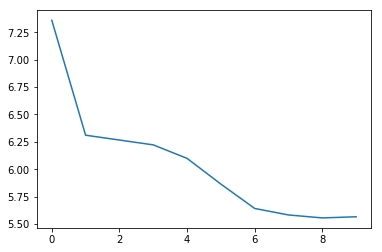

In [104]:
plt.plot(total_loss)

### Confusion Matrix

Confusion matrix, without normalization
[[ 614  569  158    0   99  713  294   13 2460   80]
 [  45 2888   97    0   83  269  528   34  835  221]
 [ 189  332  122    0  721 1438 1674   25  489   10]
 [ 141  579  188    0  656 1648 1497   41  245    5]
 [  82  276  125    0  797 1128 2240   24  321    7]
 [ 125  314  147    0  738 2040 1386   23  226    1]
 [  20  330   62    0  586  691 3202   36   71    2]
 [ 106  584  186    0  677 1432 1575   54  367   19]
 [ 334  868   97    0   32  351   76   12 2939  291]
 [  60 2801   89    0   65  197  408   22 1001  357]]


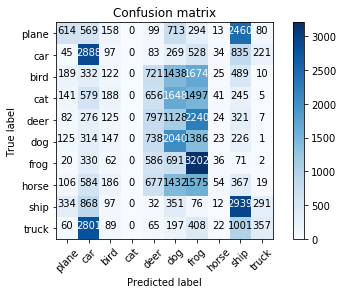

In [105]:
train_preds = get_all_preds(model, trainset)
train_preds_max=train_preds.argmax(dim=1) #tensor([6, 1, 9,  ..., 9, 8, 9])
cm = confusion_matrix(trainset.targets,train_preds_max)
plot_confusion_matrix(cm,CLASSES)